## WORK IN PROGRESS:

##Overview:

This project was inspired by seeing the difficulties experienced by small business owners like my father. The goal was to go beyond the mere observation that the Covid-19 pandemic created economic hardship: what was the relationship between Covid's spread and business difficulties? Did this relationship vary between states? Did it change over time? 
This project aims to begin answering these questions, with the hope of better equipping small business owners with the tools to react.

### Data Details: 
Economic and Covid Data is sourced primarily from Opportunity Insights Economic tracker, a database set up by Harvard researchers. I will briefly overview the data contents, but for more detail see their github and paper:

"The Economic Impacts of COVID-19: Evidence from a New Public Database Built Using Private Sector Data", by Raj Chetty, John Friedman, Nathaniel Hendren, Michael Stepner, and the Opportunity Insights Team. November 2020. Available at: https://opportunityinsights.org/wp-content/uploads/2020/05/tracker_paper.pdf

Currently, the 4 main tables/datasets I am importing are:
* StateID table, for tracking identity of region referred to in each state level dataset
* Small Business Revenue
* Consumer spending
* Spread of Covid-19 by state

Data before March 13,2020 (the date of the US declaration of national emergency over the novel coronavirus) was omitted. For further details see: https://www.whitehouse.gov/briefing-room/presidential-actions/2021/02/24/notice-on-the-continuation-of-the-national-emergency-concerning-the-coronavirus-disease-2019-covid-19-pandemic/



Further links:
*   https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_dictionary.md
*   https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_documentation.md
*   https://github.com/OpportunityInsights/EconomicTracker/tree/main/data




# Set up environment
Declare functions and import library

In [72]:
#import libraries
import pandas as pd
import numpy as np
import scipy as sc
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import math
import tqdm

from sklearn import datasets, linear_model, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
## DATA CLEANING FUNCTION STORAGE
def add_state_col(df, stateID_df, join_method):
## TO: join a target dataframe with the corresponding state ID 
  if join_method == 'join':
    print('joined state ID with target DF')
    new_df = pd.merge(df, stateID_df, how = 'left', on = 'statefips')
    new_df.rename(columns = {"statename":'state'}, inplace = True)
  else:
    #extract and transform vector of state ID for each column
    state_id_by_day = list(df['statefips'].array)
    state_list_comp_df = [(stateID_df['statename'][stateID_df['statefips'] == key].array[0]) for index,key in enumerate(state_id_by_day)]
    df['state']= state_list_comp_df
    new_df = df
  return new_df

def slice_dict(input_dict, start_indx, end_indx):
  dict_slice = [input_dict[key] for key in list(input_dict.keys())[start_indx:end_indx]]
  return dict_slice

  ## DATA CLEANING FUNCTIONS
def replace_nonnumeric_entries_df_force_nan(test_df, protected_cols):
  mutable_cols = [i for i in test_df.columns.array if i not in protected_cols]
  for index, col in enumerate(test_df.loc[:,mutable_cols].columns):
    test_df.loc[:,col] = pd.to_numeric(test_df.loc[:,col], errors = 'coerce') #force column to become numeric, returning nan if not 
  test_df = test_df.fillna(value = 0) #fill any NA values with 0 
  return test_df

def convert_obj_col_to_numeric(df): #, new_type):
  for col in df.columns:
    if df[col].dtype == object:
      df[col] = df[col].apply(pd.to_numeric, errors = 'coerce') #stack overflow version
      #original version: df[col] = df[col].astype(new_type)
  return df

def find_mutable_cols(df, protected_cols):
  mut_cols = [j for j in list(df.columns) if j not in protected_cols]
  return mut_cols

def trim_pre_covid(df):
  #date_covid_start is date that national emergency was declared 
  march_indx = [df[(df.loc[:,'month'] == 3) & (df.loc[:, 'day'] == 13) & (df.loc[:, 'year'] == 2020)].index[0]] #row in each dataframe that is equal to march 14
  return march_indx

def drop_pre_emergency_rows(target_df, emergency_index):
  ## TO: actually trim the dataframe using the fed in value
  target_df.drop(target_df.index[0:emergency_index], inplace = True)

def find_cols_with_substring(df, substring):
    #extract keys as list, extract those that contain "spend"
    all_cols = df.keys().tolist()
    #index df with that list 
    key_term = substring #this is what you use to dete4rmine if its a column of interest
    cols_to_keep = [col for col in all_cols if (key_term in col)]
    return cols_to_keep

In [3]:
#set what plot type to use 
#https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-deep')

# Import Data and evaluate format

In [4]:
#Declare URL for important opportunity tracker data 
raw_covid_rate_by_state_url = 'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/COVID%20-%20State%20-%20Daily.csv' #current to 2022-01-31
state_IDs_url = 'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/GeoIDs%20-%20State.csv' #IDs used for each state in later tables
spending_by_state_url = 'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20State%20-%20Daily.csv' #affinity is personal spending #ends 2021-11-24
revenue_by_state_url = 'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Womply%20-%20State%20-%20Daily.csv' #womply is small busines revenue #ends 2021-07-09

In [5]:
#import OT data
covid_rate_per_state = pd.read_csv(raw_covid_rate_by_state_url, dtype = 'str')
state_IDs = pd.read_csv(state_IDs_url, dtype = 'str')
spending_per_state = pd.read_csv(spending_by_state_url, dtype = 'str')
revenue_per_state = pd.read_csv(revenue_by_state_url, dtype = 'str')

Do a preliminary check on the data, inspect it for inconsistencies/mission data:

In [6]:
spending_per_state.head(1).append(spending_per_state.tail(1))

,year,month,day,statefips,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,spend_nondurables,spend_grf,spend_gen,spend_hic,spend_hcs,spend_inpersonmisc,spend_remoteservices,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,provisional
0,2020,1,1,1,d,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0
34577,2021,11,14,56,w,.212,.149,.,.2,.508,.304,.202,.0895,.92,.294,.,.234,.174,.567,.2,.247,.344,.194,.19,.236,.162,.304,1


In [7]:
covid_rate_per_state.head(1).append(covid_rate_per_state.tail(1))

,year,month,day,statefips,new_case_count,new_death_count,case_count,death_count,vaccine_count,fullvaccine_count,booster_first_count,new_vaccine_count,new_fullvaccine_count,new_booster_first_count,new_test_count,test_count,hospitalized_count,new_case_rate,case_rate,new_death_rate,death_rate,new_test_rate,test_rate,new_vaccine_rate,vaccine_rate,new_fullvaccine_rate,fullvaccine_rate,new_booster_first_rate,booster_first_rate,hospitalized_rate
0,2020,1,7,15,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,0
39047,2022,2,22,56,.,.,.,.,.,.,.,.,.,.,.,.,72,.,.,.,.,.,.,.,.,.,.,.,.,12.4


In [8]:
state_IDs.tail(1)

,statefips,statename,stateabbrev,state_pop2019
50,56,Wyoming,WY,578759


In [9]:
revenue_per_state.head(2)

,year,month,day,statefips,revenue_all,revenue_inchigh,revenue_inclow,revenue_incmiddle,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,revenue_food_accommodation,revenue_retail,merchants_all,merchants_inchigh,merchants_inclow,merchants_incmiddle,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,merchants_food_accommodation,merchants_retail
0,2020,1,10,1,-.00967,.0204,-.0179,-.00901,-.0102,.0172,-.0147,.0109,.0233,.000606,.00264,.00874,.0058,-.00249,.0075,.0182,-.0134,.00308,.00672,.00511
1,2020,1,10,2,.0168,-.00106,-.0736,.0384,.0362,-.0213,-.121,.0207,.0123,.0321,.00597,-.000315,.102,.00518,.0369,-.0471,-.041,.0109,.00395,.0142


Looks like the start of both covid_rate_per_state and econ_per_state have missing values, presumably from the fact that they are from periods before COVID-19 was detected/known about. I thus in the next section clean that data, and then set the dataframes to begin after national state of emergency was declared in 2020.

# Data cleaning:
First, left join the dataframes with the corresponding statename/population for later reference.


In [10]:
#add which state each row is taken from
spending_per_state = add_state_col(spending_per_state, state_IDs, 'join')
covid_rate_per_state = add_state_col(covid_rate_per_state, state_IDs, 'join')
revenue_per_state = add_state_col(revenue_per_state, state_IDs, 'join')

joined state ID with target DF
joined state ID with target DF
joined state ID with target DF


In [11]:
spending_per_state.head(1).append(spending_per_state.tail(1))

,year,month,day,statefips,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,spend_nondurables,spend_grf,spend_gen,spend_hic,spend_hcs,spend_inpersonmisc,spend_remoteservices,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,provisional,state,stateabbrev,state_pop2019
0,2020,1,1,1,d,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0,Alabama,AL,4903185
34577,2021,11,14,56,w,.212,.149,.,.2,.508,.304,.202,.0895,.92,.294,.,.234,.174,.567,.2,.247,.344,.194,.19,.236,.162,.304,1,Wyoming,WY,578759


In [12]:
protected_cols =['freq', 'state', 'statename', 'stateabbrev', 'state_pop2019']
revenue_per_state = replace_nonnumeric_entries_df_force_nan(revenue_per_state, protected_cols)
spending_per_state= replace_nonnumeric_entries_df_force_nan(spending_per_state, protected_cols)
covid_rate_per_state = replace_nonnumeric_entries_df_force_nan(covid_rate_per_state, protected_cols)
#remove columns before march 13, 2020
print('Row index where March 13, 2020 occurs in the Covid spread DF, the SB revenue DF, and the Consumer Spending per State are: ', trim_pre_covid(covid_rate_per_state), trim_pre_covid(revenue_per_state), trim_pre_covid(spending_per_state))
drop_pre_emergency_rows(covid_rate_per_state, trim_pre_covid(covid_rate_per_state)[0])
drop_pre_emergency_rows(spending_per_state, trim_pre_covid(spending_per_state)[0])
drop_pre_emergency_rows(revenue_per_state, trim_pre_covid(revenue_per_state)[0])


Row index where March 13, 2020 occurs in the Covid spread DF, the SB revenue DF, and the Consumer Spending per State are:  [2736] [3213] [3672]


In [13]:
#add datetime column to aid joining later
spending_per_state['datetime'] = pd.to_datetime(spending_per_state[['year', 'month', 'day']])
revenue_per_state['datetime'] = pd.to_datetime(revenue_per_state[['year', 'month', 'day']])
covid_rate_per_state['datetime'] = pd.to_datetime(covid_rate_per_state[['year', 'month', 'day']])


In [14]:
spending_per_state.head(1).append(spending_per_state.tail(1))

,year,month,day,statefips,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,spend_nondurables,spend_grf,spend_gen,spend_hic,spend_hcs,spend_inpersonmisc,spend_remoteservices,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,provisional,state,stateabbrev,state_pop2019,datetime
3672,2020,3,13,1,d,0.0209,-0.146,-0.0768,-0.227,-0.0203,-0.0249,0.259,0.4790,0.151,0.0225,0.0212,0.00652,-0.0216,0.0926,-0.245,0.139,-0.00196,-0.0187,0.0683,-0.0425,0.0171,0.0378,0,Alabama,AL,4903185,2020-03-13
34577,2021,11,14,56,w,0.2120,0.149,0.0000,0.200,0.5080,0.3040,0.202,0.0895,0.920,0.2940,0.0000,0.23400,0.1740,0.5670,0.200,0.247,0.34400,0.1940,0.1900,0.2360,0.1620,0.3040,1,Wyoming,WY,578759,2021-11-14


In [15]:
covid_rate_per_state.head(1).append(covid_rate_per_state.tail(1))
print(covid_rate_per_state.columns)

Index(['year', 'month', 'day', 'statefips', 'new_case_count',
       'new_death_count', 'case_count', 'death_count', 'vaccine_count',
       'fullvaccine_count', 'booster_first_count', 'new_vaccine_count',
       'new_fullvaccine_count', 'new_booster_first_count', 'new_test_count',
       'test_count', 'hospitalized_count', 'new_case_rate', 'case_rate',
       'new_death_rate', 'death_rate', 'new_test_rate', 'test_rate',
       'new_vaccine_rate', 'vaccine_rate', 'new_fullvaccine_rate',
       'fullvaccine_rate', 'new_booster_first_rate', 'booster_first_rate',
       'hospitalized_rate', 'state', 'stateabbrev', 'state_pop2019',
       'datetime'],
      dtype='object')


In [16]:
revenue_per_state.head(1).append(revenue_per_state.tail(1))

,year,month,day,statefips,revenue_all,revenue_inchigh,revenue_inclow,revenue_incmiddle,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,revenue_food_accommodation,revenue_retail,merchants_all,merchants_inchigh,merchants_inclow,merchants_incmiddle,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,merchants_food_accommodation,merchants_retail,state,stateabbrev,state_pop2019,datetime
3213,2020,3,13,1,-0.0705,-0.0497,-0.0443,-0.107,-0.0158,-0.131,-0.0626,-0.0834,-0.0965,-0.0312,-0.0462,-0.0472,-0.0537,-0.0372,-0.0487,-0.0387,-0.0371,-0.071,-0.0632,-0.049,Alabama,AL,4903185,2020-03-13
26587,2021,6,30,55,-0.3670,-0.3500,-0.3150,-0.385,-0.4050,-0.141,-0.2250,-0.5280,-0.5640,-0.4070,-0.4420,-0.4460,-0.4320,-0.4440,-0.4360,-0.2910,-0.3150,-0.582,-0.5900,-0.452,Wisconsin,WI,5822434,2021-06-30


Manual inspection of data shows that cleaning has been successful. I thus perform an inner join on all dataframes to ensure that dates are matched for all datapoints, and continue to perform preliminary EDA.

In [17]:
cols_of_interest = dict() #create dict where key is information type, and value is the list of columns to use that aren't indexs
cols_of_interest['covid'] = find_mutable_cols(covid_rate_per_state, protected_cols)
cols_of_interest['spending'] =  find_mutable_cols(spending_per_state, protected_cols)
cols_of_interest['revenue'] =   find_mutable_cols(spending_per_state, protected_cols)
# to make sure that the dates line up, you need to do an inner join to take the matching days of the predicted variable, and the predictor variable dataframes
join_covid_spending_revenue_df = dict() #this si a dict where every key (equal to state name) will refer to 1 df 

primary_key_cols = ['year', 'month', 'day', 'datetime', 'state','stateabbrev','state_pop2019'] #want to keep this for the primary dataframe
secondary_key_cols = ['datetime', 'state'] #this is for the df that is gonna be joined 
spending_cols_to_merge = find_cols_with_substring(spending_per_state, 'spend') + secondary_key_cols
revenue_cols_to_merge =find_cols_with_substring(revenue_per_state, 'revenue') + find_cols_with_substring(revenue_per_state, 'merchant') + secondary_key_cols

#run forloop to run and store
all_state_names = sorted(list(set(state_IDs.loc[:,'statename']))) #use set to extract unique values then combine into a sortedlist

#RUN for loop to merge all dfs
for state in all_state_names:
    #join_covid_spending_revenue_df[state] = covid_rate_per_state.set_index('datetime')
    #join_covid_spending_revenue_df[state] = pd.concat(covid_rate_per_state.loc[covid_rate_per_state['state']==state, :], spending_per_state.loc[ spending_per_state['state']==state,:], how = 'inner', left_index = True, right_on = 'datetime')
    df_base = covid_rate_per_state.loc[covid_rate_per_state['state']==state, :]
    df_add =  spending_per_state.loc[ spending_per_state['state']==state,spending_cols_to_merge] 
    join_covid_spending_revenue_df[state] = pd.merge(df_base,df_add, how = 'inner', on = ['datetime', 'state'])
    df_add_revenue = revenue_per_state.loc[revenue_per_state['state']== state, revenue_cols_to_merge]
    join_covid_spending_revenue_df[state] = pd.merge(join_covid_spending_revenue_df[state],df_add_revenue, how = 'inner', on = ['datetime', 'state'])

join_covid_spending_revenue_df[state].tail(3)

,year,month,day,statefips,new_case_count,new_death_count,case_count,death_count,vaccine_count,fullvaccine_count,booster_first_count,new_vaccine_count,new_fullvaccine_count,new_booster_first_count,new_test_count,test_count,hospitalized_count,new_case_rate,case_rate,new_death_rate,death_rate,new_test_rate,test_rate,new_vaccine_rate,vaccine_rate,new_fullvaccine_rate,fullvaccine_rate,new_booster_first_rate,booster_first_rate,hospitalized_rate,state,stateabbrev,state_pop2019,datetime,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,spend_nondurables,spend_grf,spend_gen,spend_hic,spend_hcs,spend_inpersonmisc,spend_remoteservices,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,revenue_all,revenue_inchigh,revenue_inclow,revenue_incmiddle,revenue_ss40,revenue_ss60,revenue_ss65,revenue_ss70,revenue_food_accommodation,revenue_retail,merchants_all,merchants_inchigh,merchants_inclow,merchants_incmiddle,merchants_ss40,merchants_ss60,merchants_ss65,merchants_ss70,merchants_food_accommodation,merchants_retail
302,2021,1,9,56,307.0,7.0,45874.0,467.0,0.0,0.0,0.0,0.0,0.0,0.0,3765.0,518349.0,121.0,53.0,7926.0,1.26,80.7,650.0,89562.0,0.0,0.0,0.0,0.0,0.0,0.0,20.9,Wyoming,WY,578759,2021-01-09,0.135,-0.0362,-0.0795,-0.1230,0.131,0.296,0.139,0.171,0.350,0.292,0.1010,0.0155,0.191,1.04,-0.262,0.238,0.280,0.143,0.256,0.169,0.122,0.0405,-0.195,-0.170,-0.105,-0.204,-0.0619,-0.0654,-0.526,-0.310,-0.341,-0.03860,-0.367,-0.438,-0.353,-0.360,-0.382,-0.1120,-0.353,-0.415,-0.385,-0.389
303,2021,1,10,56,280.0,7.0,46153.0,475.0,0.0,0.0,0.0,0.0,0.0,0.0,3765.0,522114.0,118.0,48.3,7975.0,1.26,82.0,650.0,90213.0,0.0,0.0,0.0,0.0,0.0,0.0,20.3,Wyoming,WY,578759,2021-01-10,0.186,0.1370,-0.0753,-0.0941,0.265,0.370,0.208,0.230,0.393,0.278,0.1490,0.1050,0.275,1.16,-0.261,0.312,0.365,0.202,0.327,0.239,0.172,0.0572,-0.179,-0.178,-0.190,-0.179,-0.0487,-0.0637,-0.541,-0.283,-0.329,0.00455,-0.355,-0.430,-0.343,-0.347,-0.371,-0.0723,-0.341,-0.412,-0.383,-0.378
304,2021,1,11,56,307.0,7.0,46460.0,482.0,0.0,0.0,0.0,0.0,0.0,0.0,2897.0,525011.0,114.0,53.0,8028.0,1.26,83.3,501.0,90713.0,0.0,0.0,0.0,0.0,0.0,0.0,19.7,Wyoming,WY,578759,2021-01-11,0.159,0.1230,-0.0729,-0.0704,0.278,0.366,0.193,0.225,0.330,0.253,0.0795,-0.0336,0.207,1.12,-0.279,0.300,0.347,0.170,0.277,0.221,0.131,0.0844,-0.169,-0.116,-0.252,-0.176,-0.0361,-0.0191,-0.554,-0.272,-0.335,-0.00456,-0.345,-0.419,-0.367,-0.335,-0.355,-0.0556,-0.323,-0.405,-0.378,-0.367


## Preliminary EDA:

Here I plot the values of the number of new case counts in each state versus the revenue of all small businesses. 


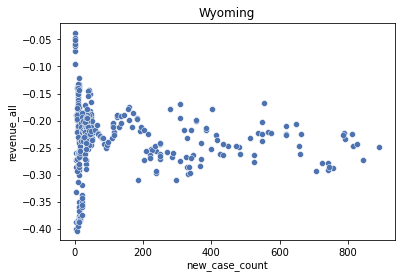

In [18]:
sns.scatterplot(x = 'new_case_count', y = 'revenue_all', palette = 'deep', data = join_covid_spending_revenue_df[state]);
plt.title(state);

# MODEL SELECTION- comparing model performance


## Simplest predictive model: Ordinary Least Squares Linear Regression with 2 input variables (new Covid-19 case rate and new Covid-19 death rate)



In [19]:
## MAIN SCRIPT THAT IS CALLED TO PERFORM LINEAR REGRESSION
def process_run_lin_reg(train_X_df,train_Y_df, test_X_df, test_Y_df, indep_vars, Y_variable):
    #TO: given a Test Data/Labels and Train Data/Labels, run linear regression on chosen values
    #transform DF into numpy array: Training set
    train_X_array, train_Y_var = prepare_data_linReg(train_X_df,train_Y_df, indep_vars, Y_variable)
    #transform DF into numpy array: Test set
    test_X_array, test_Y_var = prepare_data_linReg(test_X_df,test_Y_df, indep_vars, Y_variable)
    #run linear regression with numpy arrays of train and test sets
    linreg_r_squared, Y_full_prediction, residuals, linear_RMSE = run_linear_regression(train_X_array, train_Y_var,test_X_array, test_Y_var, indep_vars, Y_variable)
    return linreg_r_squared, Y_full_prediction, residuals, linear_RMSE

## LINEAR REGRESSION SUB FUNCTIONS
#RUNS FIRST
def prepare_data_linReg(X_data,Y_data, indep_vars, Y_variable):
    #TO: given 2 data frames, and list of names to use, create 2 numpy arrays (for independent and predicted variable)
    #X_variable is list of keys for X_data df
    Y_var = np.array(Y_data.loc[:,Y_variable].copy())
    X_array = np.array(X_data.loc[:,indep_vars].copy()) #rows are days, columns are features
    return X_array, Y_var

#RUNS SECOND
def run_linear_regression(train_X, train_Y, test_X, test_Y,indep_vars, Y_variable):
    ## MAIN MODEL RUN HERE 
    reg = LinearRegression().fit(train_X,train_Y)
    Y_test_prediction = reg.predict(test_X)
    linreg_r_squared =  round(reg.score(test_X,test_Y),3) #calculates the r2
    residuals = test_Y- Y_test_prediction
    linear_RMSE = round(mean_squared_error(test_Y, Y_test_prediction, squared = False),3) #if squared is false then outputs RMSE

    ## MODEL OUTPUTS R2, full prediction values,and residuals of prediction + RMSE
    return linreg_r_squared, Y_test_prediction, residuals, linear_RMSE

def create_test_train_split_for_covid_revenue_dfs(train_split, test_split):
    train_df_x = covid_rate_per_state.iloc[train_split, :].copy().reset_index(drop = True)
    train_df_y = revenue_per_state.iloc[train_split, :].copy().reset_index(drop = True)
    #test with 2021
    test_df_x = covid_rate_per_state.iloc[test_split, :].copy().reset_index(drop = True)
    test_df_y = revenue_per_state.iloc[test_split, :].copy().reset_index(drop = True)
    return train_df_x, train_df_y, test_df_x, test_df_y

def extract_covid_spending_revenue_forState(join_covid_spending_revenue_df, covid_features, spending_features, revenue_features):
    covid_rate_per_state = join_covid_spending_revenue_df.loc[:, covid_features]
    spending_per_state = join_covid_spending_revenue_df.loc[:, spending_features]
    revenue_per_state = join_covid_spending_revenue_df.loc[:, revenue_features]
    return covid_rate_per_state, spending_per_state, revenue_per_state

Here I'm running simple linear regression, predicting **daily consumer spending** in each state, using each state's ** New Covid-19 Case Rate and New Covid-19 Death Rate **. 

Performance is evaluated using R^2, which is a measure of the % of total variance in the variable of interest explainable by the modeled linear relationship between it and the independent variables. Essentially, it asks how much the independent variables appear to contribute to the dynamics of the dependent variables. I also record the mean squared error of the model predictions for  each state, for each model type, to quantify the overall deviation from real data

## Running time-series cross-validation
Since this data is a time-series, datapoints are not independent. Therefore, randomly partitioned cross validation would not be feasible. I thus use time-sensitive cross-validation. 
This next chunk is a loop that for each state, trains on "new death rate" and "new case rate" for that state.

In [20]:
#create storage 
predictions_OLS = dict()# store state:Y prediction list
residuals_OLS = dict() #store it for assumption testing
linreg_r_squared_mean = dict()
linreg_r_squared = dict()
r_2_linreg = list()
linear_RMSE = dict()
linear_RMSE_mean = dict()

#declare features of interest
indep_vars = ['new_death_rate','new_case_rate']
Y_variable = ['revenue_all'] #predicting REVENUE

num_splits = 5
splits = TimeSeriesSplit(n_splits = num_splits, gap = 7)

spending_features = spending_cols_to_merge
revenue_features = revenue_cols_to_merge
#extract covid cols
covid_feature_name =['count', 'rate']
covid_features = find_cols_with_substring(join_covid_spending_revenue_df[state], covid_feature_name[0]) + find_cols_with_substring(join_covid_spending_revenue_df[state], covid_feature_name[1]) +primary_key_cols

## run time dependent cross validation on all states 
for state in all_state_names:    
##rewrite pointer for DFs to refer to newly joined dataframe
    covid_rate_per_state, spending_per_state, revenue_per_state= extract_covid_spending_revenue_forState(join_covid_spending_revenue_df[state], covid_features, spending_features, revenue_features)
    #create state specific storage 
    linreg_r_squared[state] = np.empty((1,num_splits))# to store the specific r squared values for these 
    predictions_OLS[state] = np.empty((1,num_splits)) #list()
    residuals_OLS[state]  = np.empty((1,num_splits)) #list()
    linear_RMSE[state] = np.empty((1,num_splits))
    count = 0
    for train_split,test_split in splits.split(covid_rate_per_state):
        
        train_df_x, train_df_y, test_df_x, test_df_y = create_test_train_split_for_covid_revenue_dfs(train_split, test_split)

        
        #run model itself on SPECIFIC test train split
        linreg_r_squared[state][0, count], _, _, linear_RMSE[state][0, count]  = process_run_lin_reg(train_df_x, train_df_y, test_df_x, test_df_y, indep_vars, Y_variable) #requires test set and train set
        count = count +1

    linreg_r_squared_mean[state]= np.mean(linreg_r_squared[state])
    linear_RMSE_mean[state] = np.mean(linear_RMSE[state])

In [52]:
#try using a dict input
df_model_performance_by_state = pd.DataFrame.from_dict(linreg_r_squared_mean, orient = 'index', columns = ['OLSR R2'])
df_model_performance_by_state.head()

,OLSR R2
Alabama,-17.5960
Alaska,-457.0826
Arizona,-266.5548
Arkansas,-12.1186
California,-79.4392


Above is a slice of the table I created, listing 50 states and D.C. and the strength of the relationship between Covid Spread and personal Credit Card Spending from 2020-late 2021. As you can see, the range of R2 values varies widely, which is surprising. 

My Hypothesis was that the relationship between spending on a state level would be relatively similar across states. In other words, either the relationship between changes in Covid-19 rates, and changes in spending would be linearly related in a similar fashion across states, or that the relationship would be non-linear in a similar fashion across states. Instead, it appears that the relationship is linear in *some* states, but not others, which is unexpected. I further investigate potential reasons why.

## Comparing OLSR to Lasso Regression

It could be the case that additional factors besides case counts affect consumer spending. For example, spending rates might increase with vaccination rates, despite decreasing by some amount with case rates. To include more potentially informative variables while attempting to avoid issues with introducing redundant factors/colinearity, I will use Lasso regression, which introduces an L1 regularization term to the Cost Function, ideally driving coefficients for non-essential variables to zero.

I then compare the R^2 value of lasso regression on the full dataset, with ordinary least squares linear regression on the full dataset.


#### Lasso Regression Functions:

In [22]:
def normalize_array(X_array, norm_method):
  #this assumes INPUT ARRAY is columns as features, rows as observations
  X_array_norm = np.empty(X_array.shape)
  if norm_method == 'none':
        pass
        #perform no normalization
  elif norm_method == 'zscore':
        #perform z scoring on the data
        X_array_norm[:,:] = sc.stats.zscore(X_array, axis = 0)

  elif norm_method == 'normalize':
        for i in np.arange(X_array.shape[1]):
          X_array_norm[:,i] = (X_array[:,i]- np.min(X_array[:,i]))/(np.max(X_array[:,i])- np.min(X_array[:,i]))

  return X_array_norm

def process_run_lasso_reg(train_X_df,train_Y_df, test_X_df, test_Y_df,  indep_vars, Y_variable, run_cross_val, norm_method):
    #TO: given a Test Data/Labels and Train Data/Labels, run linear regression on chosen values

    #transform DF into numpy array: Training set
    train_X_array, train_Y_var = prepare_data_linReg(train_X_df,train_Y_df, indep_vars, Y_variable)
    #transform DF into numpy array: Test set
    test_X_array, test_Y_var = prepare_data_linReg(test_X_df,test_Y_df, indep_vars, Y_variable)

    lasso_reg, lasso_reg_r_squared, Y_test_prediction, lasso_RMSE = run_lasso_regression(train_X_array, train_Y_var, test_X_array, test_Y_var,run_cross_val)
    return lasso_reg, lasso_reg_r_squared,Y_test_prediction, lasso_RMSE

def run_lasso_regression(train_X,train_Y, test_X,test_Y, run_cross_val):
  #create test train split by taking random 50%

  if run_cross_val:
    lasso_reg = linear_model.LassoCV(cv = 10, tol=0.01, max_iter = 2000) #Cross-val- instantiate lasso class 

    lasso_reg_model = lasso_reg.fit(train_X,train_Y.ravel())
    Y_test_prediction = lasso_reg.predict(test_X)
    lasso_reg_r_squared = round(lasso_reg.score(test_X,test_Y.ravel()),3) #calculates the r2

  else:
    lasso_reg = linear_model.Lasso(alpha = 0.1) #instantiate lasso class 
    lasso_reg_model = lasso_reg.fit(train_X,train_Y)
    Y_test_prediction = lasso_reg.predict(test_X)
    lasso_reg_r_squared =  round(lasso_reg.score(test_X,test_Y),3) #calculates the r2

  residuals = Y_test_prediction - test_Y
  lasso_RMSE = mean_squared_error(test_Y, Y_test_prediction, squared = False) #outputs RMSE 
  return lasso_reg_model, lasso_reg_r_squared, Y_test_prediction, lasso_RMSE


#### Main body of Lasso Regression:

In [23]:
# create pure features that don't include 
numeric_covid_features = find_cols_with_substring(join_covid_spending_revenue_df[state], covid_feature_name[0]) + find_cols_with_substring(join_covid_spending_revenue_df[state], covid_feature_name[1]) 
numeric_spending_features = find_cols_with_substring(spending_per_state, 'spend') 
numeric_revenue_features = find_cols_with_substring(revenue_per_state, 'revenue') + find_cols_with_substring(revenue_per_state, 'merchant')

In [24]:

#cross validate params on one dataset to determine appropriate alphs
indep_vars = numeric_covid_features #expanding breadth of variables used 
Y_variable = ['revenue_all']
run_cross_val = True
norm_method = 'none'

#create storage variables for model and predictions
r_2_lasso = dict() #stores MEAN of all values by state
predictions_lasso = dict()
residuals_lasso = dict()

lasso_model_by_state = dict()
lasso_r_squared = dict() #stores INDIVIDUAL R2 values for each CV run by state

lasso_RMSE = dict() #stores array of INDIVIDUAL RMSE by state
lasso_RMSE_mean = dict() #stores MEAN of RMSE by state

for state in all_state_names:
    covid_rate_per_state, spending_per_state, revenue_per_state= extract_covid_spending_revenue_forState(join_covid_spending_revenue_df[state], covid_features, spending_features, revenue_features)
        #create state specific storage 
    lasso_r_squared[state] = np.empty((1,num_splits))# to store the specific r squared values for these 
    predictions_lasso[state] = list() #list()
    residuals_lasso[state]  = np.empty((1,num_splits)) #list()
    lasso_RMSE[state] = np.empty((1,num_splits))# to store the specific r squared values for these 
    lasso_model_by_state[state] = list()
    count = 0

    for train_split,test_split in splits.split(covid_rate_per_state):
        train_df_x, train_df_y, test_df_x, test_df_y = create_test_train_split_for_covid_revenue_dfs(train_split, test_split)

        #run model itself on SPECIFIC test train split 
        current_lasso_model_by_state, lasso_r_squared[state][0, count],current_lasso_predictions, lasso_RMSE[state][0, count] = process_run_lasso_reg( train_df_x, train_df_y,test_df_x, test_df_y, indep_vars, Y_variable,run_cross_val, norm_method)
        count = count+1
        
        predictions_lasso[state].append(current_lasso_predictions)
        lasso_model_by_state[state].append(current_lasso_model_by_state)

    r_2_lasso[state] = np.mean(lasso_r_squared[state])
    lasso_RMSE_mean[state] = np.mean(lasso_RMSE[state])


In [25]:
df_model_performance_by_state['LASSO R2'] =r_2_lasso.values()
df_model_performance_by_state.head()

,OLSR R2,LASSO R2
Alabama,-17.5960,-494.8010
Alaska,-457.0826,-33.1494
Arizona,-266.5548,-197.8734
Arkansas,-12.1186,-229.8704
California,-79.4392,-83.6598


In [26]:
df_model_performance_by_state['LASSO-OLSR R2 Delta'] =  df_model_performance_by_state.loc[:,'LASSO R2'].values -  df_model_performance_by_state.loc[:,'OLSR R2'].values

#import CSV of all states
states_by_region = 'https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv'
allstates_df = pd.read_csv(states_by_region)

df_model_R2_by_state = pd.merge(df_model_performance_by_state, allstates_df, how = 'inner', right_on = 'State', left_index = True)
df_model_R2_by_state.head()

,OLSR R2,LASSO R2,LASSO-OLSR R2 Delta,State,State Code,Region,Division
1,-17.5960,-494.8010,-477.2050,Alabama,AL,South,East South Central
0,-457.0826,-33.1494,423.9332,Alaska,AK,West,Pacific
3,-266.5548,-197.8734,68.6814,Arizona,AZ,West,Mountain
2,-12.1186,-229.8704,-217.7518,Arkansas,AR,South,West South Central
4,-79.4392,-83.6598,-4.2206,California,CA,West,Pacific


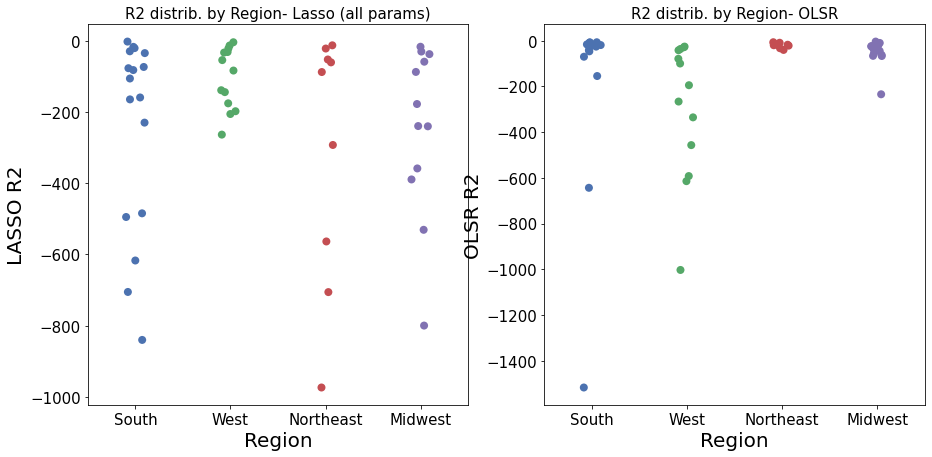

In [27]:

#create boxplot of state R2 values by region
fig, ax = plt.subplots(1,2, figsize = (15,7))
g= sns.stripplot(x = 'Region', y = "LASSO R2", data = df_model_R2_by_state, size = 8, ax = ax[0]);
ax[0].tick_params(labelsize=15)
ax[0].xaxis.label.set_fontsize(20)
ax[0].yaxis.label.set_fontsize(20)
ax[0].set_title('R2 distrib. by Region- Lasso (all params)', fontsize=15);

g= sns.stripplot(x = 'Region', y = "OLSR R2", data = df_model_R2_by_state, size = 8, ax = ax[1]);
ax[1].tick_params(labelsize=15)
ax[1].xaxis.label.set_fontsize(20)
ax[1].yaxis.label.set_fontsize(20)
ax[1].set_title('R2 distrib. by Region- OLSR', fontsize=15);

In [28]:
## TO DO:
#create graph comparing RMSE across models

df_model_performance_by_state['OLSR-RMSE'] = linear_RMSE_mean.values()
df_model_performance_by_state['Lasso-RMSE'] = lasso_RMSE_mean.values()

df_model_performance_by_state = pd.merge(df_model_performance_by_state, allstates_df, how = 'inner', right_on = 'State', left_index = True)


In [29]:

df_model_performance_by_state.head()


,OLSR R2,LASSO R2,LASSO-OLSR R2 Delta,OLSR-RMSE,Lasso-RMSE,State,State Code,Region,Division
1,-17.5960,-494.8010,-477.2050,0.1058,0.483416,Alabama,AL,South,East South Central
0,-457.0826,-33.1494,423.9332,0.4898,0.192450,Alaska,AK,West,Pacific
3,-266.5548,-197.8734,68.6814,0.3204,0.256569,Arizona,AZ,West,Mountain
2,-12.1186,-229.8704,-217.7518,0.1550,0.401417,Arkansas,AR,South,West South Central
4,-79.4392,-83.6598,-4.2206,0.2368,0.225279,California,CA,West,Pacific


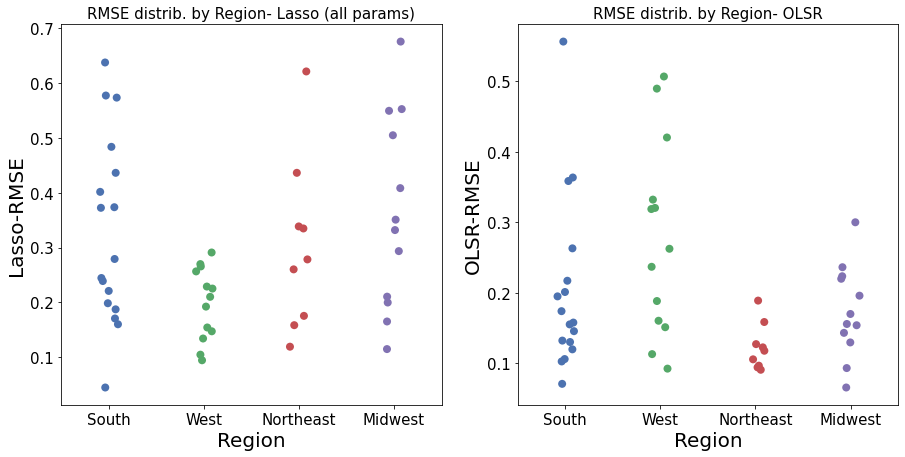

In [30]:
#create boxplot of state values by region
fig, ax = plt.subplots(1,2, figsize = (15,7))
g= sns.stripplot(x = 'Region', y = "Lasso-RMSE", data = df_model_performance_by_state, size = 8, ax = ax[0]);
ax[0].tick_params(labelsize=15)
ax[0].xaxis.label.set_fontsize(20)
ax[0].yaxis.label.set_fontsize(20)
ax[0].set_title('RMSE distrib. by Region- Lasso (all params)', fontsize=15);

g= sns.stripplot(x = 'Region', y = "OLSR-RMSE", data = df_model_performance_by_state, size = 8, ax = ax[1]);
ax[1].tick_params(labelsize=15)
ax[1].xaxis.label.set_fontsize(20)
ax[1].yaxis.label.set_fontsize(20)
ax[1].set_title('RMSE distrib. by Region- OLSR', fontsize=15);

RMSE is high for both Lasso trained on the majority of Covid-19 spread variables  and OLSR. Both models 

## Decision Tree Regression with XGBoost


In [39]:
import xgboost
from xgboost import XGBRegressor
print(xgboost.__version__)

0.90


In [108]:
#transform data into d matrix
def transform_dfs_into_dmatrix(split_index, covid_rate_per_state, revenue_per_state, indep_vars, Y_variable):

    X_data = covid_rate_per_state.iloc[split_index, :].copy().reset_index(drop = True)
    Y_data = revenue_per_state.iloc[split_index, :].copy().reset_index(drop = True)

    Y_var = np.array(Y_data.loc[:,Y_variable].copy())
    X_array = np.array(X_data.loc[:,indep_vars].copy()) #rows are days, columns are features

    train_x_dmatrix = xgboost.DMatrix(X_array, label = Y_var, feature_names = list(X_data.loc[:,indep_vars].columns)) #label is for predicted label, feature name is for later feature extraction
#print(train_x_dmatrix.feature_names)
    return train_x_dmatrix


In [ ]:

#test with 2021

test_df_x = covid_rate_per_state.iloc[test_split, :].copy().reset_index(drop = True)
test_df_y = revenue_per_state.iloc[test_split, :].copy().reset_index(drop = True)

In [124]:
def run_xgboost(covid_rate_per_state,indep_vars, Y_variable):
    model = XGBRegressor(n_estimators = 1000, objective = 'reg:squarederror')
    MSE = list()
    count = 0
    y_predictions = list()
    
    for train_split,test_split in splits.split(covid_rate_per_state):
        train_df_x, train_df_y, test_df_x, test_df_y = create_test_train_split_for_covid_revenue_dfs(train_split, test_split)

        train_X_array, train_Y_var = prepare_data_linReg(train_df_x,train_df_y, indep_vars, Y_variable)
        test_X_array, test_Y_var = prepare_data_linReg(train_df_x,train_df_y, indep_vars, Y_variable)

        model.fit(train_X_array, train_Y_var)
        y_pred_current = model.predict(test_X_array)

        current_MSE = mean_squared_error(test_Y_var,y_pred_current, squared = False) #outputs RMSE 
        y_predictions.append([y_pred_current])
        MSE.append([current_MSE])

        count = count +1
        
    return np.mean(MSE), y_predictions, model

In [125]:
MSE_xgboost_state = dict()
predictions_xgboost_state = dict()
xgboost_models_state = dict()
for state in tqdm.tqdm(all_state_names):
    
    covid_rate_per_state, spending_per_state, revenue_per_state= extract_covid_spending_revenue_forState(join_covid_spending_revenue_df[state], covid_features, spending_features, revenue_features)

    MSE_xgboost_state[state], predictions_xgboost_state[state],xgboost_models_state[state] = run_xgboost(covid_rate_per_state, indep_vars, Y_variable)



100%|██████████| 51/51 [01:02<00:00,  1.23s/it]


In [133]:
print(len(indep_varsa))

26


In [126]:
xg_test = pd.DataFrame(xgboost_models_state[state].get_booster().get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
 
pprint(MSE_xgboost_state[state])
xg_test
#plt.plot(predictions_xgboost_state[state][0])

0.0019932119411334333


,feature,importance
1,f2,1053
0,f0,770
4,f10,434
2,f25,221
3,f13,196
5,f15,123
6,f12,109
7,f1,35
8,f17,9


<BarContainer object of 26 artists>

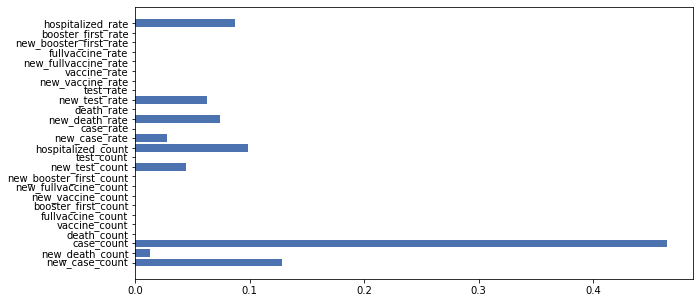

In [142]:
plt.subplots(figsize= (10,5))
plt.barh(indep_vars, xgboost_models_state[state].feature_importances_)

A specific example of a working gradient boosted tree, and what features it prioritizes to minimize prediction error. Case count is always monotonically increasing... so the model is likely using that as a proxy for time passing. In otherwords, it's cheating. Let's see what happens when we remove the cumulative case_count.

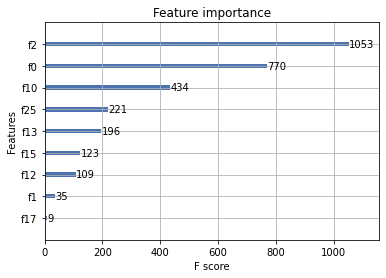

In [97]:
xgboost.plot_importance(xgboost_models_state[state])